#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [1]:
%pylab inline
import os,sys
from importlib import reload
from copy import deepcopy
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib


In [2]:
PLOT = False # Whether to actually make the plots

In [3]:
import units; reload(units); UNITS = units.UNITS

In [4]:
import boulder; reload(boulder)
import crick; reload(crick)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils)
FisherPlumes = fp.FisherPlumes

force_reload = True
n_bootstraps = 50

crick.logger.setLevel(logging.DEBUG)

if force_reload or ('Fcr' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", pitch = 7500 * UNITS.um,  freq_max = 20 * UNITS.hertz,
                       which_coords = [(0.45, 0.5),
                                       #(0.35,0.5),
                                       (0.25,0.5),
                                       #(0.15,0.5)
                                       ]*UNITS.m,
                       py_mode = "relative",
                       #suffix = 'wideDomain.orig',
                       suffix='manuscript',
                       pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
    Fcr = FisherPlumes("n12dishT",  pitch = 76000 * UNITS.um, freq_max = 100 * UNITS.hertz,
                       which_coords = [(1.0, 0.5),
                                       #(0.9,0.5),
                                       (0.7,0.5),
                                       #(0.6,0.5)
                                       ]*UNITS.m,
                      pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fcr = FisherPlumes(Fcr)
    
data = {
    "cr":Fcr,
    "bw":Fbw
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


           fisher_plumes 2023/03/22 07:45:38     INFO: ****** LOADING sim_name='boulder16' ******


           fisher_plumes 2023/03/22 07:45:38     INFO: 1 boulder16_pitch = 7500.0 µm


     fisher_plumes_tools 2023/03/22 07:45:38     INFO: Using relative py coordinates.


INFO:boulder:Loading data from file_name='Re100_0_5mm_50Hz_16source_manuscript.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_manuscript.h5 <BoulderSimulationData>
x_lim: 0 meter to 0.5 meter
y_lim: -0.21125 meter to 0.21125 meter
x-y Dimensions: [0.5 0.4225] m
x-range: 0.000 meter, 0.001 meter ... 0.500 meter (1001 points)
y-range: 0.211 meter, 0.211 meter ... -0.211 meter (846 points)
t-range: 0.000 second, 0.020 second ... 60.000 second (3001 points)
fs: 50 hertz
Sources:
  0: =    c1a @ (x = +0 meter, y = +0.00375 meter)
  1: =    c1b @ (x = +0 meter, y = -0.00375 meter)
  2: =    c2a @ (x = +0 meter, y = +0.01125 meter)
  3: =    c2b @ (x = +0 meter, y = -0.01125 meter)
  4: =    c3a @ (x = +0 meter, y = +0.01875 meter)
  5: =    c3b @ (x = +0 meter, y = -0.01875 meter)
  6: =    c4a @ (x = +0 meter, y = +0.02625 meter)
  7: =    c4b @ (x = +0 meter, y = -0.02625 meter)
  8: =    c5a @ (x = +0 meter, y = +0.03375 meter)
  9: =    c5b @ (x = +0 meter, y = -0.03375 meter)
 10: =    c6a @ (x = +0 meter, y = +0.04125 meter)
 11: =    c6b @ (x = +0 meter, y = -0.04125 m

INFO:boulder:Mapped coordinate (0.450 meter, 0.000 meter) to (0.450 meter, 0.000 meter), index (900, 422), name 'x=60 ϕ'.


INFO:boulder:Mapped coordinate (0.250 meter, 0.000 meter) to (0.250 meter, 0.000 meter), index (500, 422), name 'x=33.3 ϕ'.


INFO:boulder:Field c1a has shape (3001, 2).


INFO:boulder:Field c1b has shape (3001, 2).


INFO:boulder:Field c2a has shape (3001, 2).


INFO:boulder:Field c2b has shape (3001, 2).


INFO:boulder:Field c3a has shape (3001, 2).


INFO:boulder:Field c3b has shape (3001, 2).


INFO:boulder:Field c4a has shape (3001, 2).


INFO:boulder:Field c4b has shape (3001, 2).


INFO:boulder:Field c5a has shape (3001, 2).


INFO:boulder:Field c5b has shape (3001, 2).


INFO:boulder:Field c6a has shape (3001, 2).


INFO:boulder:Field c6b has shape (3001, 2).


INFO:boulder:Field c7a has shape (3001, 2).


INFO:boulder:Field c7b has shape (3001, 2).


INFO:boulder:Field c8a has shape (3001, 2).


INFO:boulder:Field c8b has shape (3001, 2).


     fisher_plumes_tools 2023/03/22 07:46:53     INFO: Computing pairs for len(yvals)=16 from -56250 to 56250 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/03/22 07:46:53     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2023/03/22 07:46:53     INFO: ****** LOADING sim_name='n12dishT' ******


           fisher_plumes 2023/03/22 07:46:53     INFO: 1 n12dishT_pitch = 76000.0 µm


INFO:crick:load_sims for sim_name='n12dishT' with which_coords=<Quantity([[1.  0.5]
 [0.7 0.5]], 'meter')> (py_mode='absolute').


     fisher_plumes_tools 2023/03/22 07:46:53     INFO: Using absolute py coordinates.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.7 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=-0.7 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.1 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.1 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=-0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.3 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=0.3 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.1 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=0.1 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.3 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=-0.3 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=0.7 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=0.7 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ.


DEBUG:crick:x: 0.2 - 1.1993749999999999


DEBUG:crick:y: 0.0005540315 - 0.9994492500000001


DEBUG:crick:t: 0.001 - 150.0


DEBUG:crick:probe_data: (150000, 1681)


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505 with data at 1681 locations.


INFO:crick:1 ϕ = 0.076 m


DEBUG:crick:(nx,ny,nz) = (41,41,1)


DEBUG:crick:x-range: 0.2 meter - 1.2 meter


DEBUG:crick:y-range: 0.000554 meter - 0.999 meter


DEBUG:crick:z-range: 0 meter - 0 meter


INFO:crick:Mapped coordinate (1.000 meter, 0.500 meter) to (0.999 meter, 0.500 meter), index 852, name x=7.9 ϕ, y=-0.1 ϕ.


INFO:crick:Mapped coordinate (0.700 meter, 0.500 meter) to (0.700 meter, 0.500 meter), index 840, name x=3.9 ϕ, y=-0.1 ϕ.


INFO:crick:Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


INFO:crick:Computing distance pairings.


     fisher_plumes_tools 2023/03/22 07:47:06     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/03/22 07:47:06     INFO: Removing duplicates in pairs dictionary.


INFO:crick:24 distance pairings found, from 0 to 100000


# Compute statistics all at once

In [5]:
wnd_sec_vals = [1 * UNITS.s]
dmax_um = {"bw":np.inf, "cr":np.inf}
data_wnd = {}
for wnd_sec in wnd_sec_vals:
    wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
    istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
    [(print(k, end = ""),
      sys.stdout.flush(),
      F.compute_all_for_window(wnd = wnd[k],
                               istart = istart[k],
                               window = 'boxcar',
                               tukey_param = 0,
                               dmax_um = dmax_um[k],
                               fit_vars = False,                                                                  
                               )
      ) for k, F in data.items() if k != "acr"];
    data_wnd[wnd_sec] = deepcopy(data)

cr

           fisher_plumes 2023/03/22 07:48:05     INFO: Window set to self.wnd=1000.


           fisher_plumes 2023/03/22 07:48:05     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/03/22 07:48:05     INFO: Computing coefficients for 2 probes.


           fisher_plumes 2023/03/22 07:48:08     INFO: Computing variances for harmonics.


           fisher_plumes 2023/03/22 07:48:11     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/03/22 07:48:31     INFO: Computing lambdas.


           fisher_plumes 2023/03/22 07:48:31    DEBUG: sum(freqs<=fmax)=501.


           fisher_plumes 2023/03/22 07:48:35    DEBUG: data.shape=(51, 2, 6512)


           fisher_plumes 2023/03/22 07:48:35    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/03/22 07:50:32    DEBUG: utils.d1(self.la[0]).shape=(51, 501)


           fisher_plumes 2023/03/22 07:50:32     INFO: Computing p-values.


           fisher_plumes 2023/03/22 07:50:32     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/03/22 07:51:04     INFO: Computing R^2-values.


           fisher_plumes 2023/03/22 07:51:04     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/03/22 07:51:08     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/03/22 07:51:08     INFO: Using 24 distances <= inf um 


           fisher_plumes 2023/03/22 07:51:08     INFO: Computed λ for 501 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2023/03/22 07:51:08     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/03/22 07:52:18    DEBUG: self.fit_params[0].shape=(51, 501, 3).


           fisher_plumes 2023/03/22 07:52:18    DEBUG: self.vars_for_freqs[0].shape=(51, 501).


           fisher_plumes 2023/03/22 07:52:18     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/03/22 07:52:18     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000, 15000, 18000, 20000, 22000, 25000, 30000, 40000, 45000, 48000, 50000, 52000, 55000, 60000, 70000, 100000].


           fisher_plumes 2023/03/22 07:52:19    DEBUG: self.I[0].shape=(51, 501, 27) has the expected value.


           fisher_plumes 2023/03/22 07:52:19     INFO: Done computing all for wnd=1000.


bw

           fisher_plumes 2023/03/22 07:52:19     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/03/22 07:52:19     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/03/22 07:52:19     INFO: Computing coefficients for 2 probes.


           fisher_plumes 2023/03/22 07:52:19     INFO: Computing variances for harmonics.


           fisher_plumes 2023/03/22 07:52:19     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/03/22 07:52:20     INFO: Computing lambdas.


           fisher_plumes 2023/03/22 07:52:20    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/03/22 07:52:20    DEBUG: data.shape=(51, 2, 3808)


           fisher_plumes 2023/03/22 07:52:20    DEBUG: vars.shape=(2, 51)


           fisher_plumes 2023/03/22 07:52:25    DEBUG: utils.d1(self.la[0]).shape=(51, 26)


           fisher_plumes 2023/03/22 07:52:25     INFO: Computing p-values.


           fisher_plumes 2023/03/22 07:52:25     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/03/22 07:52:26     INFO: Computing R^2-values.


           fisher_plumes 2023/03/22 07:52:26     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/03/22 07:52:27     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/03/22 07:52:27     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/03/22 07:52:27     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2023/03/22 07:52:27     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/03/22 07:52:33    DEBUG: self.fit_params[0].shape=(51, 26, 3).


           fisher_plumes 2023/03/22 07:52:33    DEBUG: self.vars_for_freqs[0].shape=(51, 26).


           fisher_plumes 2023/03/22 07:52:33     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/03/22 07:52:33     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/03/22 07:52:33    DEBUG: self.I[0].shape=(51, 26, 21) has the expected value.


           fisher_plumes 2023/03/22 07:52:33     INFO: Done computing all for wnd=50.


In [6]:
wnd_sec = wnd_sec_vals[0]
data = deepcopy(data_wnd[wnd_sec])

fig_dir_fun = lambda wnd_sec: f"figs/wnd_{wnd_sec.magnitude:g}sec"
fig_dir = fig_dir_fun(wnd_sec)
if not os.path.exists(fig_dir):
    print(f"Creating {fig_dir=}")
    os.mkdir(fig_dir)
else:
    print(f"{fig_dir=} already exists.")

fig_dir='figs/wnd_1sec' already exists.


# Figure showing an example plume and correlations

In [7]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

INFO:boulder:Loading fld='c1a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/boulder/saved-snapshots/c8b_t40.p'.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y550_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y495_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y510_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y480_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y498_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y490_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y500_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y520_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y450_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y502_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='/camp/home/tootoos/working/tootoos/data/fisher-plumes/crick/saved-snapshots/y505_S1_t40.p'.


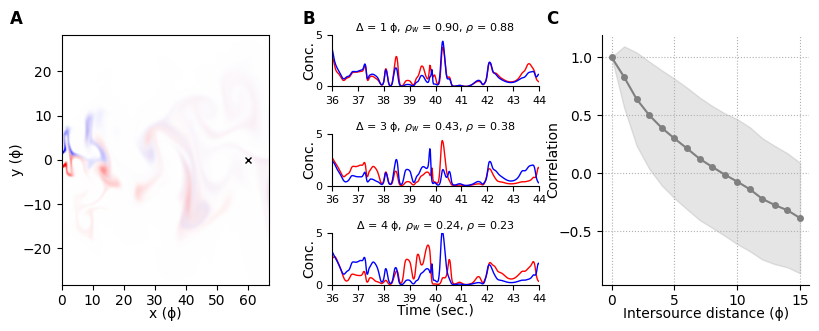

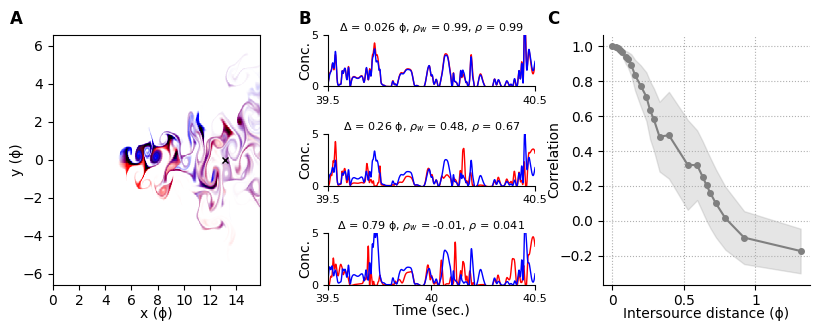

In [8]:
reload(fpf)
reload(fpft)

which_srcs   = {"bw":[-3750, 3750],        "cr":[490000,510000]}
t_wnd        = {"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}
which_idists = {"bw":[0,2,3],              "cr":[0,10,20]}
tticks       = {"bw":DEFAULT,              "cr":[39.5,40,40.5]}
xticks       = {"bw":DEFAULT,              "cr":DEFAULT}
yticks       = {"bw":DEFAULT,              "cr":DEFAULT}

for k, F in sorted(data.items()):
    data_dir = os.path.join(os.environ["FISHER_PLUMES_DATA"], {"bw":"boulder", "cr":"crick"}[k], "saved-snapshots")
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40 * UNITS.sec, which_srcs[k], y_lim = (0,5.01),
                                                        t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k], data_dir=data_dir)
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])

    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

# Set the probe index we'll use

In [9]:
iprb = 0

# Figure showing the distribution of correlations

cr
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/ma/core.py:2358: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=copy, subok=True)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


bw
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


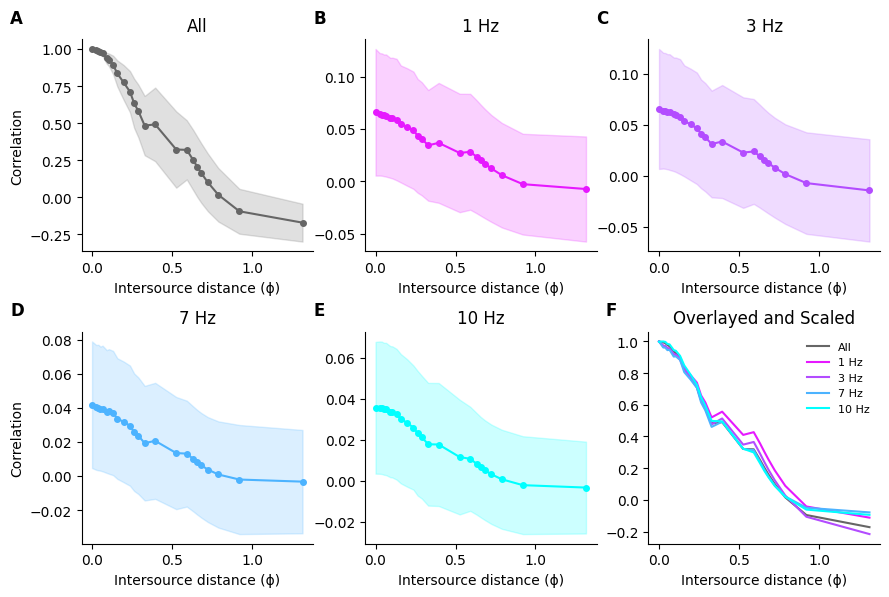

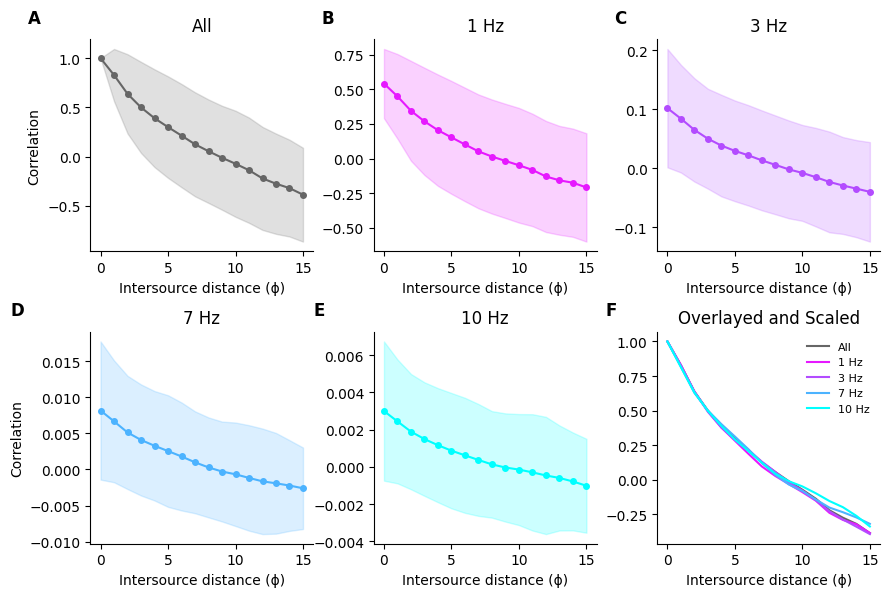

In [10]:
reload(fpf)
which_freqs = [1,3,7,10] * UNITS.hertz
labs = [f"{f}" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})
xlims_  = {"bw":DEFAULT, "cr":DEFAULT}
xticks_ = {"bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)        
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

bw
Mapped 5 Hz to index 5.
cr
Mapped 5 Hz to index 5.


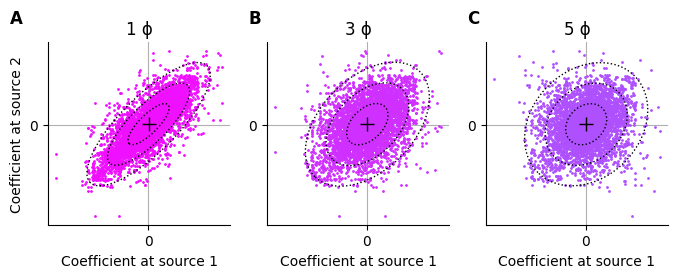

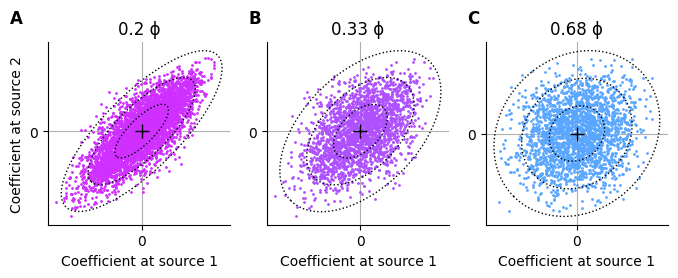

In [11]:
reload(fpf)
which_freqs = {"bw":5 * UNITS.hertz,       "cr":5 * UNITS.hertz}
which_idists= {"bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_units,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Supplementary Information

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


<Figure size 800x300 with 0 Axes>

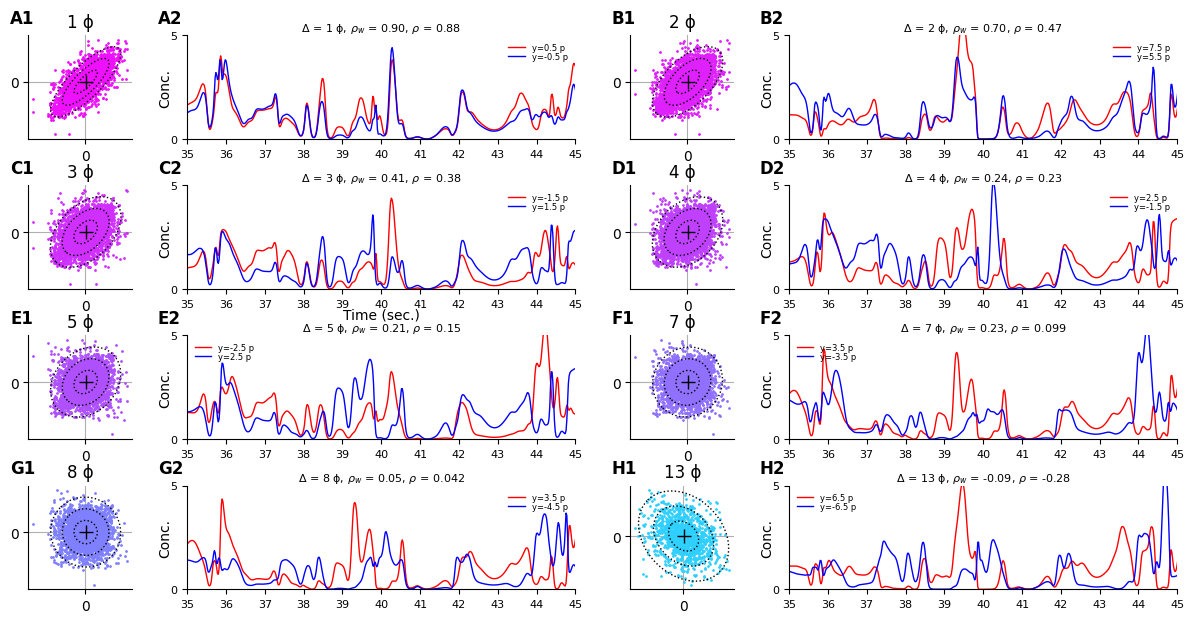

<Figure size 800x300 with 0 Axes>

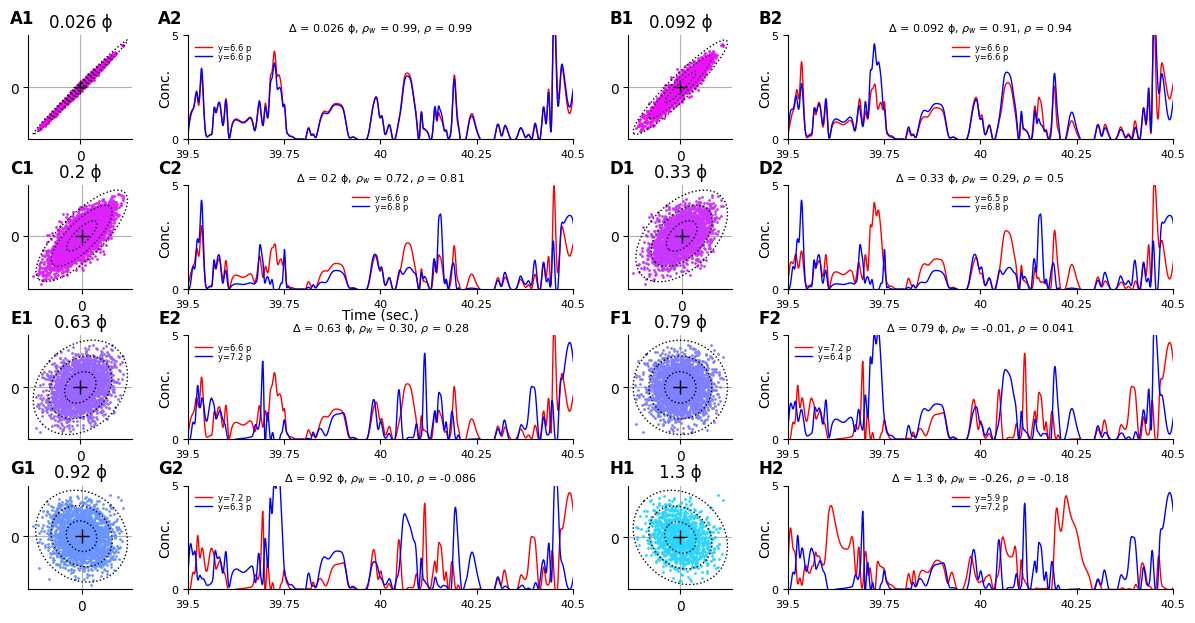

In [12]:
reload(fpf)
reload(fpft)
freq      = {"bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz}
idists    = {"bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec}
dt        = {"bw":1*UNITS.sec,              "cr":0.25*UNITS.sec}
for ws, data_ws in data_wnd.items():
    for k, F in sorted(data_ws.items()):
        figure(figsize=(12,6))
        coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                             which_probe = iprb, n_per_row = 2,
                                                             y_lim=[0,5],
                                                             t_lim = t_lim[k],
                                                             dt = dt[k])
        for ax in coef_ax:
            ax.set_xlabel("")
            ax.set_ylabel("")
        [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
        tight_layout(pad=0)
        all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
        n_ax   = len(all_ax)
        fpft.label_axes(all_ax,
                        [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                        align_x = [list(range(i,n_ax,4)) for i in range(4)],
                        align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                        fontsize=12, fontweight="bold", dy=-0.01)
        file_name = f"{fig_dir_fun(ws)}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=7500 @ Freq #   1: -np.log10(p) = 142.277
d=15000 @ Freq #   1: -np.log10(p) = 105.410
d=22500 @ Freq #   1: -np.log10(p) = 75.585
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Setting extent to [-0.5, 15.5, 0.5, 20.5].


d=7500 @ Freq #   5: -np.log10(p) = 3.393
d=15000 @ Freq #   5: -np.log10(p) = 1.215
d=22500 @ Freq #   5: -np.log10(p) = 1.713
Setting extent to [-0.5, 15.5, 0.5, 20.5].
Setting extent to [-0.5, 15.5, 0.5, 20.5].


d=7500 @ Freq #  10: -np.log10(p) = 29.570
d=15000 @ Freq #  10: -np.log10(p) = 12.817
d=22500 @ Freq #  10: -np.log10(p) = 8.230
Setting extent to [-0.5, 15.5, 0.5, 20.5].


Setting extent to [-0.5, 15.5, 0.5, 20.5].


d=2000 @ Freq #   1: -np.log10(p) = 1.847
d=25000 @ Freq #   1: -np.log10(p) = 0.519
d=52000 @ Freq #   1: -np.log10(p) = 0.429
Setting extent to [-0.5, 23.5, 0.5, 100.5].
Setting extent to [-0.5, 23.5, 0.5, 100.5].


d=2000 @ Freq #   5: -np.log10(p) = 2.532
d=25000 @ Freq #   5: -np.log10(p) = 1.676
d=52000 @ Freq #   5: -np.log10(p) = 0.815
Setting extent to [-0.5, 23.5, 0.5, 100.5].
Setting extent to [-0.5, 23.5, 0.5, 100.5].


d=2000 @ Freq #  10: -np.log10(p) = 2.531
d=25000 @ Freq #  10: -np.log10(p) = 1.708


d=52000 @ Freq #  10: -np.log10(p) = 0.462
Setting extent to [-0.5, 23.5, 0.5, 100.5].
Setting extent to [-0.5, 23.5, 0.5, 100.5].


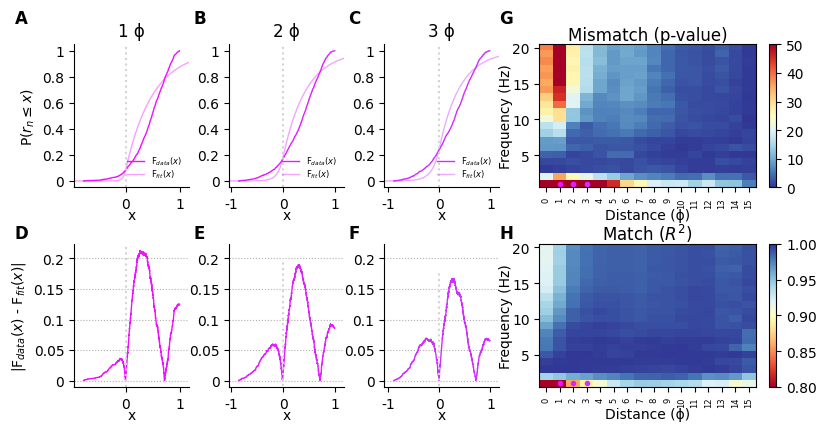

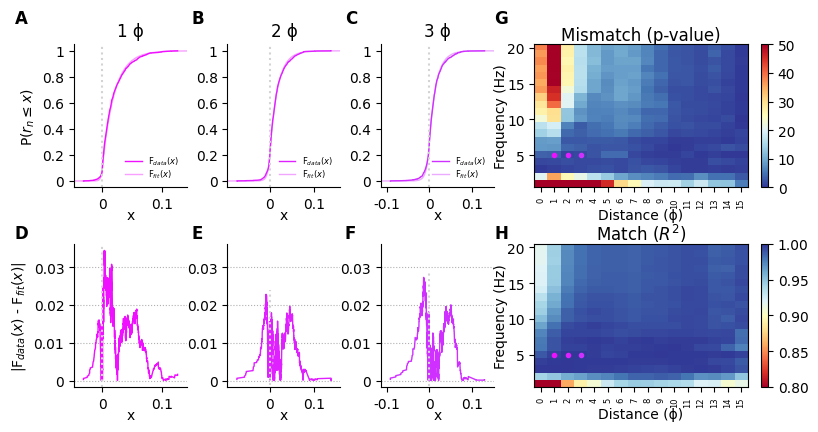

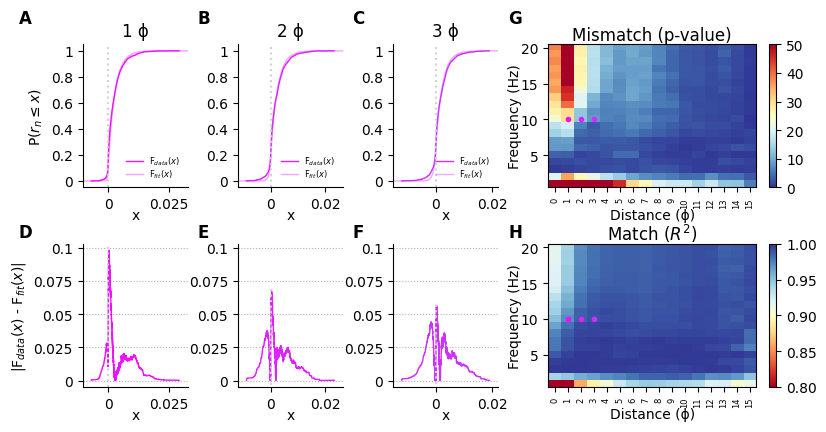

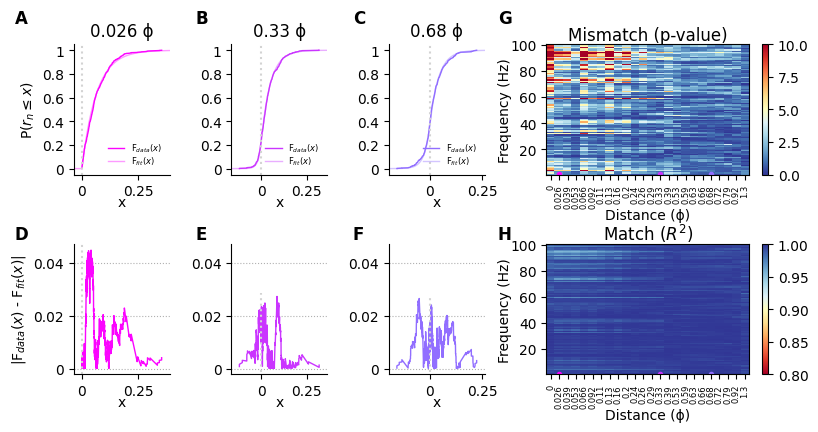

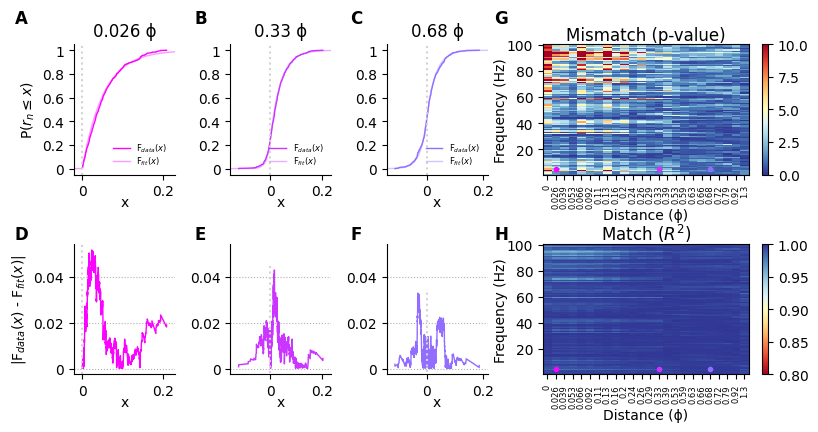

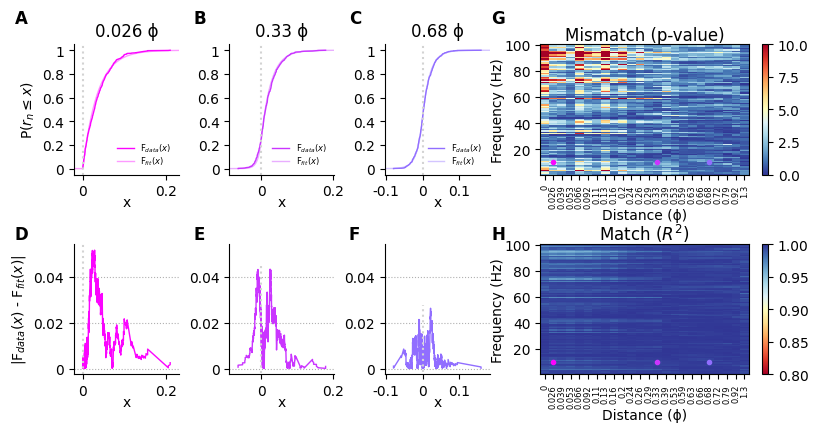

In [13]:
reload(fpft)
reload(fpf)
which_wnd_sec = wnd_sec_vals[0]
idist     = {"bw":[1,2,3],       "cr":[1,13,19]}
freq_max  = {"bw":21 * UNITS.hertz,            "cr":101 * UNITS.hertz}
vmin      = {"bw":[0,0.8],       "cr":[0,0.8]}
vmax      = {"bw":[50,1],        "cr":[10,1]}
for name, F in sorted(data_wnd[which_wnd_sec].items()):
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = {"bw":f, "cr":f}
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_fun(which_wnd_sec)}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

      fisher_plumes_figs 2023/03/22 07:53:54     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:419: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)


      fisher_plumes_figs 2023/03/22 07:53:54     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


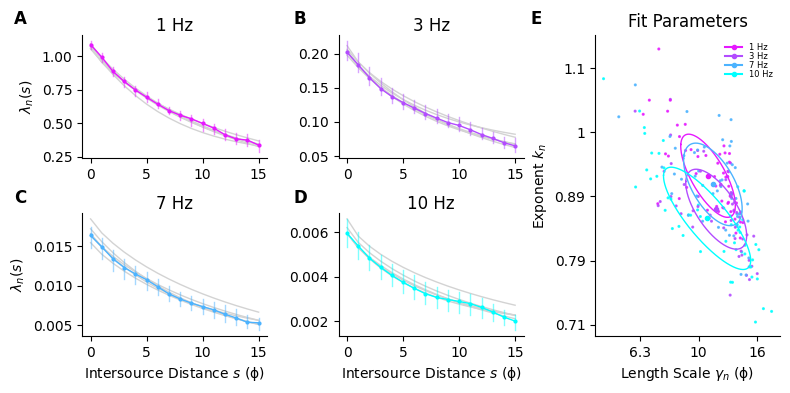

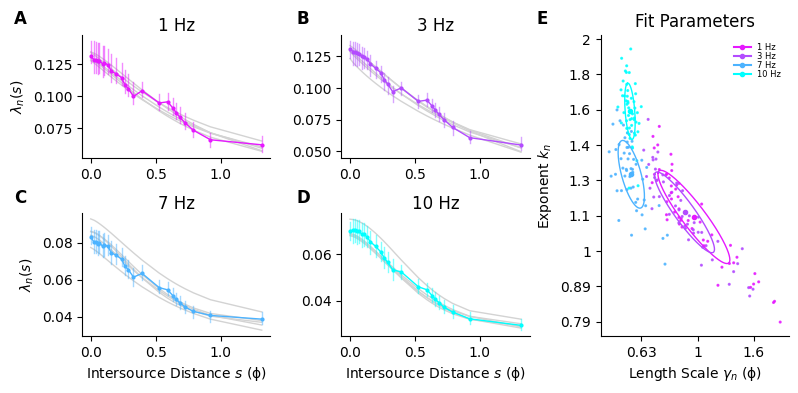

In [14]:
reload(fpft)
reload(fpf)
xl     = {"bw":(-10,200),                 "cr": (-2, 50)}
freqs  = {"bw":[1,3,7,10] * UNITS.hertz,  "cr": [1,3,7,10] * UNITS.hertz}
xt     = {"bw":arange(0,201,50),          "cr": arange(0,101,25)}
xtp    = {"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])}
ytp    = {"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher Information

      fisher_plumes_figs 2023/03/22 07:54:01     INFO: dd[0]=100, dd[-1]=200000


      fisher_plumes_figs 2023/03/22 07:54:02     INFO: Plotting which_ifreqs=[1, 4, 5, 6].


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:539: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/ma/core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
      fisher_plumes_figs 2023/03/22 07:54:02     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 4, 5, 6], log_scale=True.


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:419: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:425: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)
      fisher_plumes_figs 2023/03/22 07:54:02     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 4, 5, 6], log_scale=True.


      fisher_plumes_figs 2023/03/22 07:54:02     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 4, 5, 6], log_scale=True.


      fisher_plumes_figs 2023/03/22 07:54:02     INFO: dd[0]=100, dd[-1]=100000


      fisher_plumes_figs 2023/03/22 07:54:04     INFO: Plotting which_ifreqs=[64, 2, 69, 73, 78, 79, 22, 86, 30].


      fisher_plumes_figs 2023/03/22 07:54:04     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 22, 30, 64, 69, 73, 78, 79, 86], log_scale=True.


      fisher_plumes_figs 2023/03/22 07:54:04     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 22, 30, 64, 69, 73, 78, 79, 86], log_scale=True.


      fisher_plumes_figs 2023/03/22 07:54:04     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 22, 30, 64, 69, 73, 78, 79, 86], log_scale=True.


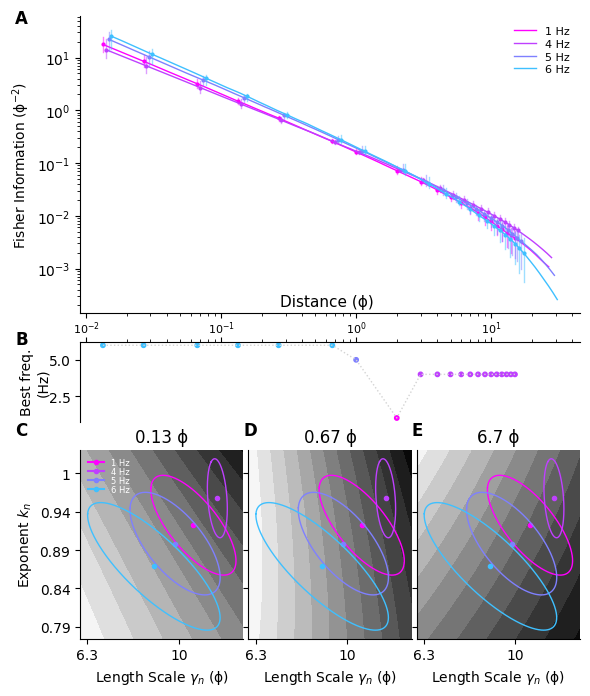

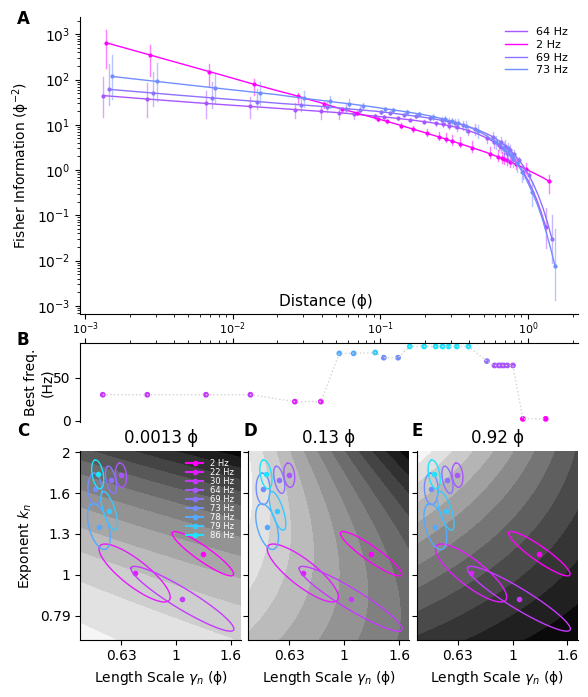

In [15]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs["bw"] = [1, 3, 7, 10] * UNITS.hertz
freqs["cr"] = [10,20,30,40] * UNITS.hertz
freq_max  = {"bw":20 * UNITS.hertz, "cr":100 * UNITS.hertz}
colscale  = {"bw":10, "cr":40}
d_vals_um = {"bw":[1,5,50], "cr":[0.1,10,70]}
d_lim_um  = {"bw":[100, 200000 * 1], "cr":[100, 100000 * 1]}
bf_ytick  = {"bw":arange(0,13,4), "cr":None}
for k, F in sorted(data.items()):
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_range_um = list(range(100,1000,100)) + list(range(1000,10000,1000))+list(range(10000,60000,10000)),
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.05**i),
                                                                fi_scale  = 1, plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
    )
    tight_layout(h_pad=0,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    align_y = [[2,3,4]],
                    align_x = [[0,1,2]],
                    fontsize=12, fontweight="bold", dy=-0.01)                            
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));
    

# Plot best frequency for each probe

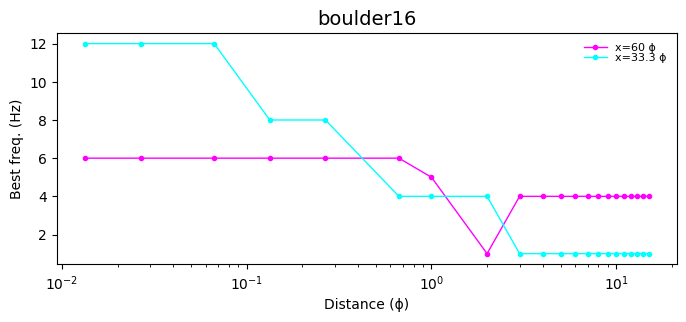

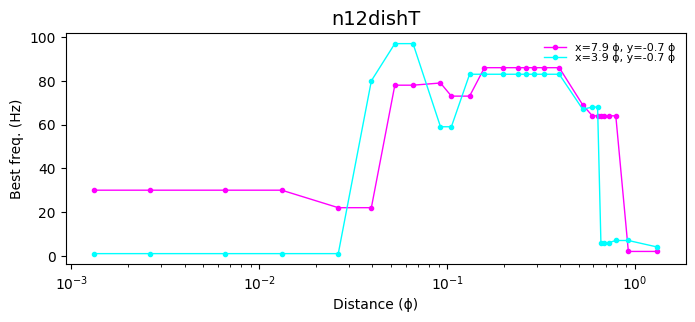

In [16]:
for k, F in sorted(data.items()):
    probe_coords = utils.d1(F.sims).get_used_probe_coords()
    probe_xcoords_sorted = sorted([p[0] for p in probe_coords])
    probe_names = utils.d1(F.sims).coord_strs
    n_probes = len(probe_coords)
    figure(figsize=(8,3))
    dd = F.I_dists/F.pitch.to(UNITS.um).magnitude
    for which_probe, (px,py) in enumerate(probe_coords):
        semilogx(dd, F.freqs[F.I_best_ifreqs[which_probe]],
                 "o-",markersize=3, linewidth=1, color = cm.cool(probe_xcoords_sorted.index(px)/(n_probes-1)), label=probe_names[which_probe])
    xlabel("Distance (ϕ)")
    ylabel("Best freq. (Hz)")
    title(F.name, fontsize=14)
    legend(frameon=False, labelspacing=0, fontsize=8)
    file_name = f"{fig_dir}/best_freq_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));
        


# Plot the Power in each Signal

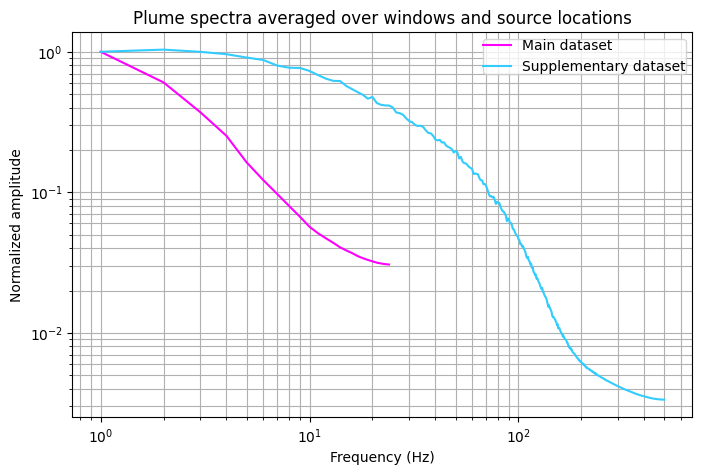

In [17]:
for wnd_in_sec, data in data_wnd.items():
    figure(figsize=(8,5))
    for k, F in sorted(data.items()):
        f = []
        for _, s in F.sims.items():
            fs = F.fs.to(UNITS.hertz).magnitude
            fr, ti, S = stft(s.data[:,iprb], fs = fs, window='boxcar',
                             nperseg=int(fs), noverlap=fs//2, boundary=None, padded=False)
            f.append(np.abs(S))
            
        f = np.array(f)
        a = np.mean(f,axis=-1).mean(axis=0)    
        loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1], label="Supplementary dataset" if k=="cr" else "Main dataset", color={"bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
    legend(borderpad=0)
    xlabel("Frequency (Hz)")
    ylabel("Normalized amplitude")
    title("Plume spectra averaged over windows and source locations")
    grid(True, which='both')
    file_name = f"{fig_dir_fun(wnd_in_sec)}/spectra.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));